#                             PINN + CDM for Tensile Fracture with Horizontal Crack
# ======================================================
## This code implements a Physics-Informed Neural Network (PINN) combined with Continuum Damage Mechanics (CDM) to simulate fracture in a brittle material (e.g., cast iron) with a horizontal crack under tensile loading. The top edge is pulled upward, and damage evolution is tracked in the domain.

## References:
#### 1. Raissi, M., Perdikaris, P., & Karniadakis, G. E. (2019). Physics-informed neural networks.Journal of Computational Physics, 378, 686–707.
#### 2. Miehe, C., Welschinger, F., & Hofacker, M. (2010). Thermodynamically consistent phase-field models of fracture: Variational principles and multi-field FE implementations.

## Governing Equation (2D plane strain with damage):
## $$∇·((1-d)σ) = 0  in Ω$$
### where σ is the stress tensor and d ∈ [0,1] is the damage variable.


In [24]:
import torch                                # PyTorch for model building
import torch.nn as nn                        # Neural network components
import numpy as np                           # Numerical operations
import matplotlib.pyplot as plt              # Plotting utilities

In [25]:
# Use GPU if available, otherwise fallback to CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [26]:
# Material Properties for a brittle material (Cast Iron)
E = 110e9         # Young's modulus in Pascals
nu = 0.28         # Poisson's ratio


In [27]:
#  Geometry and Mesh Functions
# These functions define the square domain, horizontal crack, and edges

def normalize_coords(x, y):
    # Normalize from [0, 1] to [-1, 1] for better neural network performance
    return 2 * x - 1, 2 * y - 1

def generate_collocation_points(N):
    # Generate N random points in domain excluding crack region
    x = np.random.rand(N, 1)
    y = np.random.rand(N, 1)
    coords = np.hstack([x, y])
    # Mask to exclude horizontal crack region (0.25 < x < 0.75 and y ≈ 0.5)
    mask = ~((coords[:, 0] > 0.25) & (coords[:, 0] < 0.75) & (np.abs(coords[:, 1] - 0.5) < 0.01))
    coords = coords[mask]
    # Normalize coordinates to [-1, 1]
    x_norm, y_norm = normalize_coords(coords[:, 0:1], coords[:, 1:2])
    return torch.tensor(np.hstack([x_norm, y_norm]), dtype=torch.float32).to(device)

def generate_edge_points(N, y_val):
    # Generate points along top or bottom edge (y_val = 1.0 or 0.0)
    x = np.linspace(0, 1, N).reshape(-1, 1)
    y = np.full_like(x, y_val)
    x, y = normalize_coords(x, y)
    return torch.tensor(np.hstack((x, y)), dtype=torch.float32).to(device)

def generate_fixed_corner():
    # Fix bottom-left corner to prevent rigid body motion
    x, y = normalize_coords(np.array([[0.0]]), np.array([[0.0]]))
    return torch.tensor(np.hstack((x, y)), dtype=torch.float32).to(device)

In [28]:
#  Define the Physics-Informed Neural Network architecture
class PINN_CDM(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 64), nn.Tanh(),         # Input: (x, y) → hidden layer1
            nn.Linear(64, 64), nn.Tanh(),        # Hidden layer2
            nn.Linear(64, 3)                     # Output: ux, uy, damage
        )

    def forward(self, x):
        return self.net(x)

In [29]:
# Compute stress tensor from predicted displacements
# Includes damage degradation (1 - d)
def compute_stress(ux, uy, xy, d):
    # Compute gradients of displacement w.r.t. coordinates
    grads_ux = torch.autograd.grad(ux.sum(), xy, create_graph=True)[0]
    grads_uy = torch.autograd.grad(uy.sum(), xy, create_graph=True)[0]

    # Strain components
    u_xx, u_xy = grads_ux[:, 0:1], grads_ux[:, 1:2]
    u_yx, u_yy = grads_uy[:, 0:1], grads_uy[:, 1:2]

    # Linear strain tensor
    eps_xx = u_xx
    eps_yy = u_yy
    eps_xy = 0.5 * (u_xy + u_yx)

    # Plane strain constitutive relation (σ = Cε), scaled by (1 - d)
    coeff = E / (1 - nu**2)
    sigma_xx = (1 - d) * coeff * (eps_xx + nu * eps_yy)
    sigma_yy = (1 - d) * coeff * (eps_yy + nu * eps_xx)
    sigma_xy = (1 - d) * E / (2 * (1 + nu)) * 2 * eps_xy

    return sigma_xx, sigma_yy, sigma_xy


In [30]:
#  Define Loss Functions for PDE, Boundary, and Damage Regularization

def pde_residual(xy):
    # Forward pass: get predicted displacements and raw damage
    out = model(xy)
    ux, uy, d_raw = out[:, 0:1], out[:, 1:2], out[:, 2:3]
    d = torch.sigmoid(d_raw)  # Sigmoid to constrain damage ∈ (0,1)

    # Compute stress components
    sigma_xx, sigma_yy, sigma_xy = compute_stress(ux, uy, xy, d)

    # Compute divergence of stress: ∇·σ = 0
    grad_sigma_xx = torch.autograd.grad(sigma_xx.sum(), xy, create_graph=True)[0]
    grad_sigma_yy = torch.autograd.grad(sigma_yy.sum(), xy, create_graph=True)[0]
    grad_sigma_xy = torch.autograd.grad(sigma_xy.sum(), xy, create_graph=True)[0]

    # PDE residual equations
    eq1 = grad_sigma_xx[:, 0:1] + grad_sigma_xy[:, 1:2]  # ∂σ_xx/∂x + ∂σ_xy/∂y
    eq2 = grad_sigma_yy[:, 1:2] + grad_sigma_xy[:, 0:1]  # ∂σ_yy/∂y + ∂σ_xy/∂x

    # Return PDE loss (mean squared residuals)
    return (eq1**2).mean() + (eq2**2).mean()

def bc_loss(xtop, xbot, xcorner):
    # Displacement boundary conditions:
    # Top edge uy = +1e-5 (tensile), Bottom edge ux = uy = 0
    out_top = model(xtop)
    out_bot = model(xbot)
    out_corner = model(xcorner)

    # Top edge uy should match prescribed displacement
    loss_top = ((out_top[:, 1:2] - 1e-5)**2).mean()
    # Bottom edge fixed
    loss_bot = (out_bot**2).mean()
    # Fix rigid motion by pinning one corner
    loss_corner = (out_corner**2).mean()

    return loss_top + loss_bot + loss_corner


In [31]:
def damage_reg(xy):
    # L2 norm of gradient of damage field: ∫ |∇d|^2 dx
    d_raw = model(xy)[:, 2:3]
    grads = torch.autograd.grad(d_raw.sum(), xy, create_graph=True)[0]
    return (grads**2).mean()


In [32]:
# Training Setup
model = PINN_CDM().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)


In [33]:
# Generate collocation and boundary points
xy = generate_collocation_points(5000)
xy.requires_grad = True
xtop = generate_edge_points(200, 1.0)      # Top edge
xbot = generate_edge_points(200, 0.0)      # Bottom edge
xcorner = generate_fixed_corner()          # Fixed point


In [40]:
# Training loop
loss_history = []
for epoch in range(3000):
    optimizer.zero_grad()
    loss = pde_residual(xy) + bc_loss(xtop, xbot, xcorner) + 1e-2 * damage_reg(xy)
    loss.backward()
    optimizer.step()
    loss_history.append(loss.item())

    if epoch % 200 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.2e}")


Epoch 0, Loss: 7.79e+15
Epoch 200, Loss: 5.74e+15
Epoch 400, Loss: 4.47e+15
Epoch 600, Loss: 3.61e+15
Epoch 800, Loss: 2.99e+15
Epoch 1000, Loss: 2.52e+15
Epoch 1200, Loss: 2.15e+15
Epoch 1400, Loss: 1.84e+15
Epoch 1600, Loss: 1.59e+15
Epoch 1800, Loss: 1.39e+15
Epoch 2000, Loss: 1.21e+15
Epoch 2200, Loss: 1.06e+15
Epoch 2400, Loss: 9.34e+14
Epoch 2600, Loss: 8.21e+14
Epoch 2800, Loss: 7.21e+14



Load–Displacement Result:
Avg Top Displacement: -2.142e-02 m
Approx. Reaction Force: -1.876e+09 N


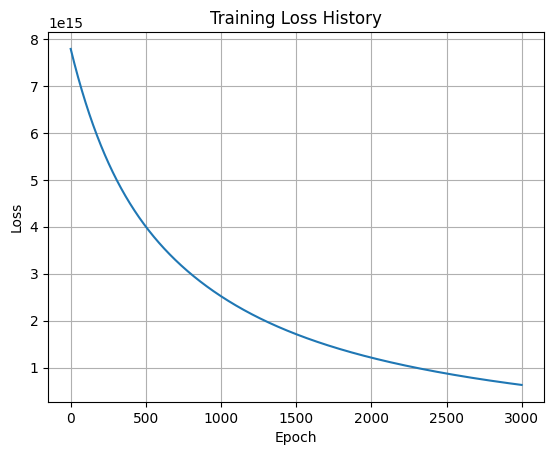

In [41]:
# Load–Displacement Curve (Static Evaluation)
# Evaluate average vertical displacement and corresponding average vertical stress
xtop.requires_grad_(True)  # Enable gradient tracking
out_top = model(xtop)
uy_top = out_top[:, 1]
d_top = torch.sigmoid(out_top[:, 2:3])
sigma_xx, sigma_yy, sigma_xy = compute_stress(out_top[:, 0:1], uy_top.unsqueeze(1), xtop, d_top)
reaction_force = sigma_yy.mean().item()
avg_disp = uy_top.mean().item()

print(f"\nLoad–Displacement Result:")
print(f"Avg Top Displacement: {avg_disp:.3e} m")
print(f"Approx. Reaction Force: {reaction_force:.3e} N")

# 📈 Plot Training Loss Curve
plt.plot(loss_history)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss History")
plt.grid(True)
plt.show()


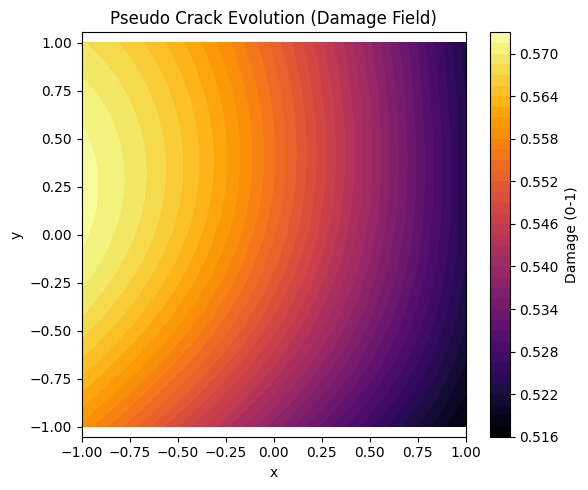

In [42]:
# Pseudo Crack Trajectory Visualization
# Generate a grid to visualize the damage field and infer crack path
x_lin = np.linspace(-1, 1, 100)
y_lin = np.linspace(-1, 1, 100)
X, Y = np.meshgrid(x_lin, y_lin)
grid = np.stack([X.ravel(), Y.ravel()], axis=-1)
grid_tensor = torch.tensor(grid, dtype=torch.float32).to(device)

damage_raw = model(grid_tensor)[:, 2:3]
damage = torch.sigmoid(damage_raw).cpu().detach().numpy().reshape(100, 100)

plt.figure(figsize=(6, 5))
plt.contourf(X, Y, damage, levels=50, cmap='inferno')
plt.colorbar(label='Damage (0-1)')
plt.title('Pseudo Crack Evolution (Damage Field)')
plt.xlabel('x')
plt.ylabel('y')
plt.axis('equal')
plt.tight_layout()
plt.show()


In [43]:
# 🎞️ Animate Damage Evolution During Training
import matplotlib.animation as animation
from IPython.display import HTML

# Reinitialize model and optimizer
model = PINN_CDM().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

damage_frames = []
xy = generate_collocation_points(3000)
xy.requires_grad = True
xtop = generate_edge_points(100, 1.0)
xbot = generate_edge_points(100, 0.0)
xcorner = generate_fixed_corner()

snapshot_interval = 100
for epoch in range(1000):
    optimizer.zero_grad()
    loss = pde_residual(xy) + bc_loss(xtop, xbot, xcorner) + 1e-2 * damage_reg(xy)
    loss.backward()
    optimizer.step()

    if epoch % snapshot_interval == 0 or epoch == 999:
        d_snapshot = torch.sigmoid(model(grid_tensor)[:, 2:3])
        d_snapshot = d_snapshot.cpu().detach().numpy().reshape(100, 100)
        damage_frames.append(d_snapshot)

# Animate using imshow for better compatibility
fig, ax = plt.subplots(figsize=(6, 5))
img = ax.imshow(damage_frames[0], extent=[-1, 1, -1, 1], origin='lower', cmap='inferno', vmin=0, vmax=1)
fig.colorbar(img, ax=ax)
ax.set_title('Damage Evolution')
ax.set_xlabel('x')
ax.set_ylabel('y')

# Animation update function
def animate(i):
    img.set_data(damage_frames[i])
    ax.set_title(f"Epoch {i * snapshot_interval}")
    return [img]

ani = animation.FuncAnimation(fig, animate, frames=len(damage_frames), interval=500, blit=True)
plt.close()
HTML(ani.to_jshtml())
